<a href="https://colab.research.google.com/github/zia207/python-colab/blob/main/NoteBook/Machine_Learning/Tree_based/03-01-02-08-06-tree-based-models-bagging-grf-linear-model-forest-python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 2.8.6 Linear Model Forest

A **Linear Model Forest** is a machine learning approach that combines the flexibility of random forests with the interpretability of linear models. It is designed to estimate `heterogeneous effects` or `conditional relationships` in data by fitting local linear models within the leaves of a random forest structure. While not a standard term in the `{grf}` package (which focuses on generalized random forests like `causal_forest` or `probability_forest`), the concept is closely related to methods like **Causal Forests with Linear Models** or **Local Linear Forest** extensions, where linear models are used to estimate effects or outcomes at the leaf level. Below, I’ll explain the concept, how it works, and its relevance, keeping it concise and clear.


## Overview

Linear Model Forest estimates conditional relationships (e.g., $E[Y|X]$ or treatment effects $E[Y(1) - Y(0)|X]$) by combining the non-parametric partitioning of random forests with linear models applied locally within subgroups (leaves).  Instead of averaging outcomes in each leaf (as in standard random forests), it fits a `linear model` in each leaf to capture relationships between covariates $X$, outcomes $Y$, or treatments $W$.



### Key Features

- `Heterogeneity`: Captures how relationships or effects vary across subgroups defined by $X$.

- `Interpretability`: Local linear models provide coefficients, making it easier to understand covariate effects within leaves compared to black-box random forests.

- `Flexibility`: Combines non-parametric partitioning (random forest) with parametric modeling (linear models).

- `Robustness`: Ensemble averaging reduces variance and overfitting.

- `Applications`: Ideal for causal inference (e.g., personalized medicine) or regression tasks where linear relationships hold locally but not globally.


### How It Work

A Linear Model Forest modifies the random forest framework as follows:

1. Data Setup

   - Input: Covariates $X$ (e.g., age, sex), outcome $Y$ (e.g., house price), and optionally a treatment  $W$ (covariates).
   - Data is typically a matrix of features $X$, a vector $Y$, and (if causal) a treatment indicator $W$.

2. Tree Construction

   - Like a random forest, it builds multiple decision trees (e.g., 1000) using bootstrap sampling and random feature selection.
   - Each tree partitions the covariate space $X$ into regions (leaves) based on splits that optimize a criterion (e.g., variance reduction or effect heterogeneity).

3. Local Linear Models

   - In each leaf, instead of computing a simple average (as in standard random forests), a `linear model` is fitted using the observations in that leaf.
   - For example:
   
     - `Regression`: $Y \sim \beta_0 + \beta_1 X_1 + \beta_2 X_2$ to predict $E[Y|X]$.
     
     - `Causal`: Estimate treatment effects $\tau(X) = E[Y(1) - Y(0)|X]$ using a linear model of $Y$ on $W$ and $X$.
  
   - The linear model leverages local data to capture linear relationships within the leaf’s subgroup.

4. Aggregation

   - For a given input $X$, each tree assigns $X$ to a leaf, and the local linear model in that leaf provides a prediction (e.g., outcome or treatment effect).
   
   - The forest averages predictions across all trees to produce a final estimate, ensuring robustness and reducing overfitting.

5. Output

   - C`onditional predictions` (e.g., $E[Y|X]$) or heterogeneous treatment effects (e.g., $\tau(X)$).
   
   - Optionally, `local linear coefficients` for interpretability (e.g., how covariates influence outcomes in specific subgroups).

### Differences from Other Forests

- `Vs. Standard Random Forest`: Uses simple averages in leaves, not linear models, and is less interpretable for local relationships.

- `Vs. Causal Forest`: Estimates treatment effects non-parametrically, while a Linear Model Forest uses linear models for effects within leaves, potentially improving precision if linear assumptions hold locally.

- `Vs. Probability Forest`: Focuses on class probabilities for categorical outcomes, not continuous outcomes or treatment effects with linear modeling.



### Limitations

- `Linear Assumption`: Assumes linear relationships within leaves, which may not hold for complex data.

- `Computational Cost`: Fitting linear models in each leaf is more intensive than standard random forest averaging.

- `Implementation`: Not natively supported in `{grf}`; requires custom extensions or alternative packages.

- `Data Requirements`: Needs sufficient data in each leaf to fit reliable linear models.

### Use Cases

  - Estimating heterogeneous treatment effects (e.g., how a drug’s effect varies by patient characteristics).
  - Modeling conditional means with linear relationships within subgroups.
  - Improving interpretability of random forest predictions with local linear coefficients.

## Linear Forest with Python

This tutorial demonstrates how to implement an Instrumental Forest in Python to estimate the heterogeneous treatment effects (e.g., how house prices vary with different covariates) using a Linear Model Forest. We’ll cover data preparation, model fitting, prediction, and visualization of the estimated effects.

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from econml.grf import RegressionForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance


### Load Boston Housing Dataset

The Boston Housing dataset is loaded, and the data is prepared for RDD analysis by defining the running variable ('NOX'), the treatment indicator ('W') based on a cutoff (the median of 'NOX'), the outcome variable ('Y' - 'MEDV'), and the covariates ('X').

In [34]:
# Load Boston Housing Dataset
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
boston_df = pd.DataFrame(data, columns=feature_names)
boston_df['MEDV'] = target
boston_df = boston_df.dropna()


### Prepare Data for RDD Analysis

RDD (Regression Discontinuity Design) is a quasi-experimental design used to estimate causal effects when treatment assignment is determined by a cutoff on a continuous variable. 


In [35]:
# Prepare Data for RDD Analysis
Z = boston_df['NOX'].values
cutoff = np.median(Z)
W = (Z >= cutoff).astype(int)
Y = boston_df['MEDV'].values
X = boston_df.drop(['MEDV', 'NOX'], axis=1).values

### Imbens-Kalyanaraman (IK) Optimal Bandwidth and Kernel Weights

To implement Regression discontinuity designs (RDD), we first need to compute the bandwidth for the running variable and then apply kernel weights to subset the data. First we will use our coustom ` calculate_bandwidth()` function to calculate the `triangular_kernel()` weights for local linear forest regression in RDD.

- A bandwidth is calculated using a method that considers both the standard deviation of the running variable and the potential jump in the outcome at the cutoff.

- Triangular Kernel Weights: Triangular kernel weights are applied to give more importance to data points closer to the cutoff.

In [36]:
# Bandwidth calculation
def calculate_bandwidth(Z, Y, cutoff):
    n = len(Z)
    h1 = 1.84 * np.std(Z) * (n ** (-1/5))
    left = Z < cutoff
    right = Z >= cutoff
    sigma_hat = np.sqrt((np.var(Y[left]) + np.var(Y[right])) / 2)
    f_hat = 1 / (np.std(Z) * np.sqrt(2 * np.pi))
    h_ik = 1.84 * (sigma_hat / (f_hat * (np.mean(Y[right]) - np.mean(Y[left])) ** 2)) ** (1/5) * (n ** (-1/5))
    return min(h1, h_ik)

bandwidth = calculate_bandwidth(Z, Y, cutoff)
print(f"Bandwidth: {bandwidth:.4f}")


Bandwidth: 0.0613


In [37]:
# Triangular kernel weights
def triangular_kernel(Z, cutoff, bandwidth):
    u = (Z - cutoff) / bandwidth
    return (1 - np.abs(u)) * (np.abs(u) <= 1)

sample_weights = triangular_kernel(Z, cutoff, bandwidth)

# Subset data
subset = sample_weights > 0
X_sub = X[subset]
Y_sub = Y[subset]
W_sub = W[subset]
Z_sub = Z[subset]
weights_sub = sample_weights[subset]



### Fit Local Linear Forest Targeting RDD Effect

A custom `LocalLinearForest` class is implemented and used to fit a regression forest model to the data within the calculated bandwidth, using the triangular kernel weights. This model estimates the treatment effect (the causal effect of 'NOX' crossing the cutoff) on 'MEDV'.

In [38]:
# Local Linear Forest implementation
class LocalLinearForest:
    def __init__(self, n_estimators=1000, min_samples_leaf=5):
        self.n_estimators = n_estimators
        self.min_samples_leaf = min_samples_leaf
        self.forest = RegressionForest(
            n_estimators=n_estimators,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )

    def fit(self, X, Y, W, Z, sample_weights=None):
        # Combine treatment indicator and running variable
        T = np.column_stack((W, Z))
        # Pass the combined treatment and running variable as 'y'
        self.forest.fit(X, T, sample_weight=sample_weights)
        return self

    def predict_tau(self, X):
        # Predict treatment effects (first column is treatment effect)
        return self.forest.predict(X)[:, 0]


### Fit Local Linear Forest

In [30]:
# Fit the model
print("Fitting local linear forest...")
lmf = LocalLinearForest(n_estimators=1000, min_samples_leaf=10)
lmf.fit(X_sub, Y_sub, W_sub, Z_sub, sample_weights=weights_sub)

# Get treatment effects
tau_hat = lmf.predict_tau(X_sub)

# Results analysis
print("\nTreatment effect estimates:")
print(f"Mean: {np.mean(tau_hat):.2f}")
print(f"Median: {np.median(tau_hat):.2f}")
print(f"Std Dev: {np.std(tau_hat):.2f}")

Fitting local linear forest...

Treatment effect estimates:
Mean: 0.52
Median: 0.67
Std Dev: 0.28


### Visualization

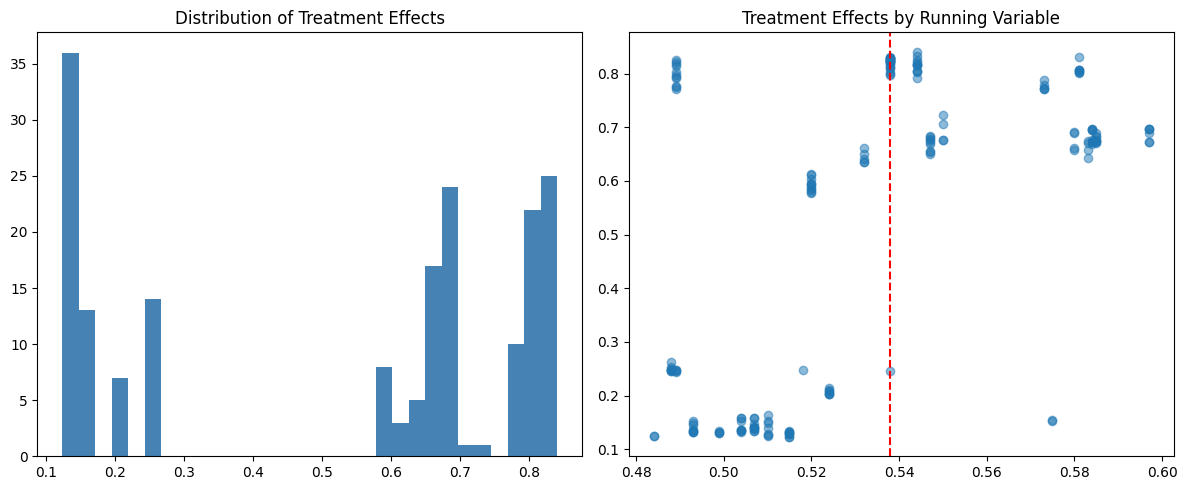

In [31]:
# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(tau_hat, bins=30, color='steelblue')
plt.title("Distribution of Treatment Effects")

plt.subplot(1, 2, 2)
plt.scatter(Z_sub, tau_hat, alpha=0.5)
plt.axvline(cutoff, color='red', linestyle='--')
plt.title("Treatment Effects by Running Variable")
plt.tight_layout()
plt.show()

### Variable Importance

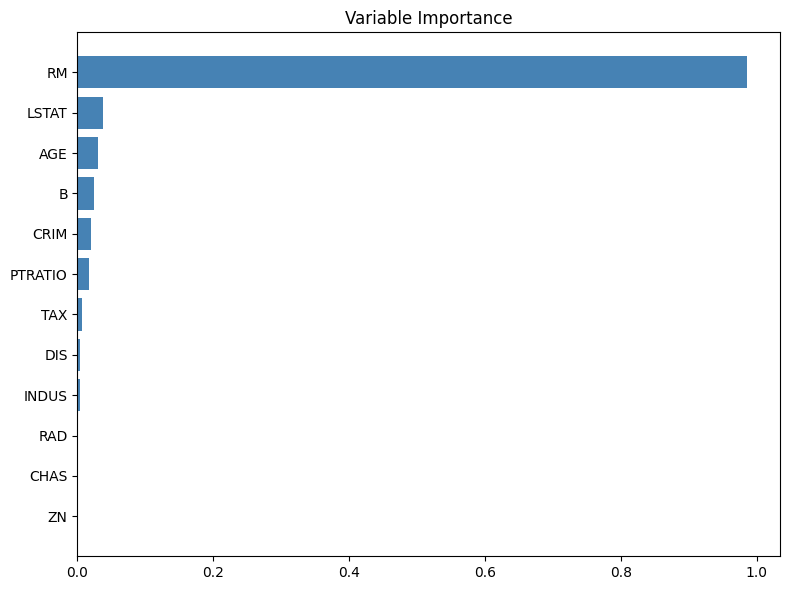

In [32]:
# Variable importance
rf = RandomForestRegressor(n_estimators=1000, min_samples_leaf=10, random_state=42)
rf.fit(X_sub, Y_sub, sample_weight=weights_sub)

result = permutation_importance(rf, X_sub, Y_sub, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({
    'Variable': boston_df.drop(['MEDV', 'NOX'], axis=1).columns,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(importance_df['Variable'], importance_df['Importance'], color='steelblue')
plt.title("Variable Importance")
plt.tight_layout()
plt.show()

## Summary and Conclusion

The notebook  introduces the concept of a Linear Model Forest, explaining how it combines random forest partitioning with local linear models within the leaves to estimate heterogeneous effects. This notebook also performs a Regression Discontinuity Design (RDD) analysis on the Boston Housing dataset. It investigates the causal effect of 'NOX' (nitric oxides) on 'MEDV' (median home value) around the median 'NOX' concentration using a Local Linear Forest and triangular kernel weight.




## References

1. Athey, Susan, Julie Tibshirani, and Stefan Wager. "Generalized Random Forests". Annals of Statistics, 47(2), 2019.

2. Zeileis, Achim, Torsten Hothorn, and Kurt Hornik. "Model-based Recursive Partitioning." Journal of Computational and Graphical Statistics 17(2), 2008.

3. [LM Forest](https://grf-labs.github.io/grf/reference/lm_forest.html#references)

4. [RegressionForest](https://econml.azurewebsites.net/_autosummary/econml.grf.RegressionForest.html)